In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/street-view-house-nos-h5-file/SVHN_single_grey1.h5


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import h5py
filepath = '/kaggle/input/street-view-house-nos-h5-file/SVHN_single_grey1.h5'
data = {}
f = h5py.File(filepath)
for k, v in f.items():
    data[k] = np.array(v)
data.keys()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


dict_keys(['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val'])

In [4]:
def return_random_indices(data, max_samples=10000, seed = 10):
    np.random.seed(seed)
    indices = np.random.choice(np.arange(data.shape[0]),
                               max_samples,
                               replace=False)
    return indices


train_X = data["X_train"][return_random_indices(data["X_train"])]
train_y = data["y_train"][return_random_indices(data["y_train"])]
test_X = data["X_test"][return_random_indices(data["X_test"], 1000)]
test_y = data["y_test"][return_random_indices(data["y_test"], 1000)]
test_y[test_y == 10] = 0

In [5]:

def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
       
train_X, test_X = prepare_for_neural_network(train_X, test_X)

In [6]:
def random_split_train_val(X, y, num_val, seed=25):
    '''
    Randomly splits dataset into training and validation.
    
    Args:
    X (numpy array): an array of training samples.
    y (numpy array): an array of training labels.
    num_val (int): a number of samples to put into validation dataset.
    seed (int): a seed for pseudo random number generator.
    
    Returns:
    train_X (numpy array): a training dataset of samples.
    train_y (numpy array): a training dataset of labels.
    val_X (numpy array): a validation dataset of samples.
    val_y (numpy array): a validation dataset of labels.
    '''
    np.random.seed(seed)
    
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    train_indices = indices[:-num_val]
    train_X = X[train_indices]
    train_y = y[train_indices]

    val_indices = indices[-num_val:]
    val_X = X[val_indices]
    val_y = y[val_indices]

    return train_X, train_y, val_X, val_y

train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

Firstly We initiate a ReLU layer class. Class has two functions: forward and backward. Functions computes a forward pass or forward propagation and backward pass or backpropagation consequently.
Remind you that relu function is:
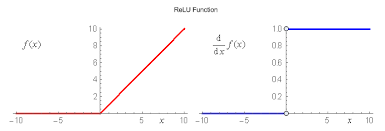

In [7]:
class ReLULayer:
    def __init__(self):
        pass

    def forward(self, X):
        try:
            self.X = X # saves input data for backpropagation implementation.
            output = np.where(X > 0, X, 0) # in accordance with definition of ReLU: return X if X > 0,
            return output                  # 0 otherwise.
        except:
            raise Exception("Not implemented!")

    def backward(self, d_out):
        """
        Performs backward pass of gradient from a loss function.
        
        Args:
        d_out (numpy array (batch_size, num_features)): gradient of loss function with 
        respect to output.
        
        Returns:
        d_result (numpy array (batch_size, num_features)): gradient with respect to input.
        """
        try:
            dReLU = np.where(self.X > 0, 1, (np.where(self.X < 0, 0, self.X))) # derivative for ReLU:
            d_result = dReLU * d_out                                           # dReLU = 1 if X > 0,
            return d_result                                                    # dReLU = 0 if X <= 0.
        except:
            raise Exception("Not implemented!")

    def params(self):
        # ReLU Doesn't have any parameters
        return {}

For checking a ReLU layer we use special functions: gradient_check and check_layer_gradient:

In [8]:
def check_gradient(f, x, delta=1e-5, tol=1e-4, verbose=False):
    '''
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula.
    
    Args:
      f (func): a function that receives x and computes value and gradient.
      x (numpy array of float): an initial point where gradient is checked.
      delta (float): a step to compute numerical gradient.
      tol (float): a tolerance for comparing numerical and analytical gradients.
      
    Returns:
      (bool): an indication whether gradients are match or mismatch.
    '''
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float

    fx, analytic_grad = f(x)
    analytic_grad = analytic_grad.copy()

    assert analytic_grad.shape == x.shape
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        value = x[ix]
        x[ix] = value + delta
        fx_plus_delta = f(x)
        x[ix] = value - delta
        fx_minus_delta = f(x)
        x[ix] = value # restore value
        grad[ix] = (fx_plus_delta[0] - fx_minus_delta[0]) / (2 * delta)
        
        if verbose:
            print(ix, grad[ix])
        
        analytic_grad_at_ix = analytic_grad[ix]
        numeric_grad_at_ix = grad[ix]

        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (
                  ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()
    print("Gradient check passed!")
    return True
    
def check_layer_gradient(layer, x, delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the input and output of a layer
    Arguments:
      layer: neural network layer, with forward and backward functions
      x: starting point for layer input
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient
    Returns:
      bool indicating whether gradients match or not
    """
    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(x):
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        grad = layer.backward(d_out)
        return loss, grad

    return check_gradient(helper_func, x, delta, tol)

Let's check our ReLU layer!

In [9]:
X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


Hooray! Gradient check passed!

Let's build a fully conecting layer.We'll use a Param class for storing our parameters: weights and biases. This make possible all parameters accumulation in one place.

In [10]:
class Param:
    """
    Trainable parameter of the model
    Captures both parameter value and the gradient
    """

    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)


class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(0.001 * np.random.randn(n_input, n_output))
        self.B = Param(0.001 * np.random.randn(1, n_output))
        self.X = None

    def forward(self, X):
        try:
            output = np.dot(X, self.W.value) + self.B.value
            self.X = X
            self.output = output
            return output
        except:
            raise Exception("Not implemented!")

    def backward(self, d_out):
        """
        Backward pass computes gradient with respect to input and
        accumulates gradients within self.W and self.B.
        
        Arg:
        d_out (numpy array (batch_size, n_output)): gradient
           of loss function with respect to output.
        
        Returns:
        d_input (numpy array (batch_size, n_input)): gradient
          with respect to input.
        """
        try:
            d_input = np.dot(d_out, self.W.value.T)
            dW = np.dot(self.X.T, d_out)
            dB = np.dot(np.ones_like(self.output).T, d_out)[0].reshape(1,-1)
            self.W.grad += dW
            self.B.grad += dB
            return d_input
        except:
            raise Exception("Not implemented!")

    def params(self):
        return {'W': self.W, 'B': self.B}

In [11]:
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)

Gradient check passed!


In [12]:
def check_layer_param_gradient(layer, x,
                               param_name,
                               delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the parameter of the layer.
    
    Args:
      layer (class): neural network layer, with forward and backward functions.
      x (numpy array): starting point for layer input.
      param_name (class param): name of the parameter.
      delta (float): step to compute numerical gradient.
      tol (float): tolerance for comparing numerical and analytical gradient.
      
    Returns:
      bool: indicating whether gradients match or not.
    """
    param = layer.params()[param_name]
    initial_w = param.value

    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(w):
        param.value = w
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        layer.backward(d_out)
        grad = param.grad
        return loss, grad

    return check_gradient(helper_func, initial_w, delta, tol)

In [13]:
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!


## Build a Neural Net.

In [14]:
def l2_regularization(W, reg_strength):
    '''
    Computes L2 regularization loss on weights and its gradient.
    
    Args:
      W (numpy array): weights.
      reg_strength (float): regularization strength value.
      
    Returns:
      loss (single value): l2 regularization loss.
      gradient (numpy array same shape as W): gradient of weight by l2 loss.
    '''
    try:
        l2_regularization_loss = reg_strength * np.sum(np.square(W))
        gradient = 2 * reg_strength * W
        return l2_regularization_loss, gradient
    except:
        raise Exception("Not implemented!")

def softmax(input_values):
    '''
    Computes probabilities from scores.
    
    Args:
      input_values (numpy array shape (N,) or (batch_size, N)): a classifier output.
      
    Returns:
      estimated_probabilities (numpy array of the same shape as input values): an estimated probability
      for every class.
    '''
    try:
        values = input_values.copy()
        if values.ndim == 1:
            values -= np.max(values)#  shift values inside the vector for numeric stability of rapidly
                                    #  increasing exponential function.
            estimated_probabilities = np.exp(values) / np.sum(np.exp(values))
        else:
            max_values = np.max(values, axis=1).reshape(-1,1)
            values = values - max_values
            estimated_probabilities = np.exp(values) / np.sum(np.exp(values), axis = 1).reshape(values.shape[0], -1)
        
        return estimated_probabilities
    
    except:
        raise Exception("Not implemented!")


def cross_entropy_loss(estimated_distribution, target_index, epsilon=1e-12):
    '''
    Computes cross-entropy loss.
    
    Args:
      estimated_distribution (numpy array, shape (N,) or (batch_size, N)): probabilities for every class.
      target_index (numpy array of int, shape (1,) or (batch_size,)): index of the true class 
      in given sample(s), showing at which index an estimated distibution should be max.
      
    Returns:
      a single value.
    '''
    try:
        if target_index is not np.array:
            target_index = np.array(target_index)
        
        if estimated_distribution.ndim == 1:
            estimated_distribution = estimated_distribution.reshape(1,-1)
            
        rows = estimated_distribution.shape[0]
        true_distribution = np.zeros_like(estimated_distribution)
        columns = target_index.flatten()
        true_distribution[np.arange(rows), columns] = 1
        return (- np.sum(true_distribution * np.log(estimated_distribution))) / estimated_distribution.shape[0]
    except:
        raise Exception("Not implemented!")        

def softmax_with_cross_entropy(input_values, target_index):
    '''
    Computes softmax and cross-entropy loss for model predictions,
    including the gradient.
    
    Args:
      input_values (numpy array, shape (N,) or (batch_size, N)): a classifier output.
      target_index (numpy array of int, shape (1,) or (batch_size,)): an index of the true 
      class for given sample(s).
      
    Returns:
      loss (a single value): cross-entropy loss.
      gradient (numpy array, input_values.shape): a gradient of cross entopy error function
      with a softmax derivative.
    '''
    try:            
        estimated_distribution = softmax(input_values)
        loss = cross_entropy_loss(estimated_distribution, target_index)
        
        if estimated_distribution.ndim == 1:
            estimated_distribution = estimated_distribution.reshape(1,-1)
            
        rows = estimated_distribution.shape[0]
        true_distribution = np.zeros_like(estimated_distribution)
        
        if target_index is not np.array:
            target_index = np.array(target_index)
        
        columns = target_index.flatten()
        true_distribution[np.arange(rows), columns] = 1
        gradient = (estimated_distribution - true_distribution) / estimated_distribution.shape[0]
        if input_values.ndim == 1:
            gradient = gradient.reshape(input_values.shape) # done only for gradient check
        return loss, gradient
    except:
        raise Exception("Not implemented!")

class TwoLayerNet:
    """ Neural network with two fully connected layers """

    def __init__(self, n_input, n_output, hidden_layer_size, reg):
        """
        Initializes the neural network.
        
        Args:
        n_input (int): dimension of the model input.
        n_output (int): number of classes to predict.
        hidden_layer_size (int): number of neurons in the hidden layer.
        reg (float): L2 regularization strength.
        """
        self.reg = reg
        self.layers = [FullyConnectedLayer(n_input, hidden_layer_size), ReLULayer(), 
                       FullyConnectedLayer(hidden_layer_size, n_output)]

    def compute_loss_and_gradients(self, X, y, verbose=False):
        """
        Computes total loss and updates parameter gradients
        on a batch of training examples.
        
        Arg:
        X (numpy array (batch_size, input_features)): input data.
        y (numpy array of int (batch_size)): classes (labels).
        
        Returns:
        loss (float): function loss.
        """
        try:
            layer_count = 0
            for layer in self.layers:
                if layer.params():
                    layer.params()["W"].grad = 0# set all gradients from previous pass to zero
                    layer.params()["B"].grad = 0
                    
                    if verbose: # for testing purpose only; look on changing weights...
                        layer_count += 1
                        print(f'Layer_{layer_count} weights are {layer.params()["W"].value[:1]}')
                        print()
            
            self.L = Param(0) # create object of overall model parameters: input values X and gradient
            self.L.value = X  # of loss function with respect to input dL/dX
                              # found it usefull only for model gradient check.
                              # Since this function makes forward and backward pass through all layers,
                              # it is impossible to get correct gradient check for layer weights,
                              # (in case of storing weights in model param())
                              # because it treats weights as X (input vector) and pass through all
                              # layers... 
                              # Model parameters stores in layer objects.
                              # In a Trainer object we call self.model.params() and it is reasonable to
                              # copy all layer weight to model params(), is it?
                              # Using multiclass inheritance with the same method name makes it
                              # cumbersome (https://stackoverflow.com/questions/3810410/python-multiple-inheritance-from-different-paths-with-same-method-name)
            self.input = X
            l2_reg_loss_cost = 0
            for layer in self.layers:
                self.input = layer.forward(self.input) # makes a forward pass of input data
                if layer.params():
                    l2_reg_loss, _ = l2_regularization(layer.params()["W"].value, self.reg) # accumulates all L2 regularization cost
                    l2_reg_loss_cost += l2_reg_loss                     # for loss function
                    
            self.loss, self.d_input = softmax_with_cross_entropy(self.input, y)
            
            self.loss += l2_reg_loss_cost # add regualraization cost from forward pass to loss function
            
            for layer in reversed(self.layers):
                self.d_input = layer.backward(self.d_input) # makes a backward pass
                if layer.params():
                    _, grad_l2_reg_loss_cost = l2_regularization(layer.params()["W"].value, self.reg) # computes L2 regularization
                    layer.params()["W"].grad = layer.params()["W"].grad + grad_l2_reg_loss_cost       # for weights and add it 
            self.L.grad = self.d_input
            
            return self.loss
        except:
            raise Exception("Not implemented!")

    def predict(self, X):
        """
        Produces classifier predictions on the set.
        
        Args:
          X (numpy array (test_samples, num_features)): input data.
        
        Returns:
          y_pred (numpy array of int (test_samples)): predicted labels.
        """
        try:
            y_pred = np.zeros(X.shape[0], np.int)
            self.input_to_predict = X
            for layer in self.layers:
                self.input_to_predict = layer.forward(self.input_to_predict) # makes a forward pass of input data
            y_pred = np.argmax(softmax(self.input_to_predict), axis=1)
            return y_pred
        except:
            raise Exception("Not implemented!")

    def params(self):
        try:
            return {"model_loss": self.L} # we aggregate weights and biases in layers objects
        except:
            raise Exception("Not implemented!")

In [15]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])
loss

2.3017431274073696

In [16]:
model.layers

In [17]:
model.params()['model_loss'].value.shape, model.params()['model_loss'].grad.shape 

((2, 1024), (2, 1024))

In [18]:
def check_model_gradient(model, X, y,
                         delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for all model parameters.
    
    Args:
      model: neural network model with compute_loss_and_gradients.
      X: batch of input data.
      y: batch of labels.
      delta: step to compute numerical gradient.
      tol: tolerance for comparing numerical and analytical gradient
    
    Returns:
      bool: indicating whether gradients match or not.
    """
    params = model.params()

    for param_key in params:
        print("Checking gradient for %s" % param_key)
        param = params[param_key]
        initial_w = param.value

        def helper_func(w):
            param.value = w
            loss = model.compute_loss_and_gradients(X, y)
            grad = param.grad
            return loss, grad

        if not check_gradient(helper_func, initial_w, delta, tol):
            return False

    return True

We'll check model loss function gradient dL with respect to the input vector X, in another words dL/dX = dL/dZn dZn/dAn-1 dAn-2/dZn-1 ... dZ/dX and we should remember that dL/dZn = dL/dAn dAn/dZn. dAn = d(SoftMAX)n and dAn-1, dAn-2, dAn-3 =  d(ReLU)n-1 d(ReLU)n-2 d(ReLU)n-3, as well dZ = d(WX + B).

In [19]:
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for model_loss
Gradient check passed!


True

![Overfitted_Data](https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Overfitted_Data.png/300px-Overfitted_Data.png)

Overfitting usually requires the output of the model to be sensitive to small changes in the input data (i.e. to exactly interpolate the target values, you tend to need a lot of curvature in the fitted function). The bias parameters don't contribute to the curvature of the model, so there is usually little point in regularising them as well. [source](https://stats.stackexchange.com/questions/153605/no-regularisation-term-for-bias-unit-in-neural-network).

In [20]:
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e-1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)
check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for model_loss
Gradient check passed!


True

In [21]:
def multiclass_accuracy(prediction, ground_truth):
    '''
    Computes metrics for multiclass classification.
    
    Args:
        prediction (numpy array of int): model predictions.
        ground_truth (numpy array of int): true labels.
        
    Returns:
        accuracy: ratio of accurate predictions to total samples.
    '''
    confusion_matrix = np.zeros((10,10), np.int)
    index = tuple(np.array(list(zip(prediction,ground_truth))).T)
    np.add.at(confusion_matrix, index, 1) # np.ix_(prediction, ground_truth)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()
    return accuracy

In [22]:
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30])

0.06666666666666667

## Let's write a code for trainer.

### Let's implement stochastic gradient descent

>Stochastic gradient descent (often abbreviated SGD) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in high-dimensional optimization problems this reduces the computational burden, achieving faster iterations in trade for a lower convergence rate [wiki](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).
![gradient_descent](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQuTCrPEvKWAvM8DblI0fIJxEFhmApkBF-eog&usqp=CAU)

In stochastic (or "on-line") gradient descent, the true gradient of Q(w) is approximated by a gradient at a single example:

![update_weights](https://wikimedia.org/api/rest_v1/media/math/render/svg/dda3670f8a8996a0d3bf80856bb4a166cc8db6d4)

As the algorithm sweeps through the training set, it performs the above update for each training example. Several passes can be made over the training set until the algorithm converges. If this is done, the data can be shuffled for each pass to prevent cycles. Typical implementations may use an adaptive learning rate so that the algorithm converges.

In [23]:
class SGD:
    """
    Implements vanilla SGD update.
    """
    def update(self, w, d_w, learning_rate, batch_size):
        """
        Performs SGD update.
        
        Args:
        w (numpy array): weights.
        d_w (numpy array, same shape as w): gradient.
        learning_rate (float): learning rate.
        
        Returns:
        updated_weights (numpy array same shape as w): updates weights.
        """
        return w - d_w * learning_rate

In [24]:
from copy import deepcopy
import scipy.io as io

class Dataset:
    """
    Utility class to hold training and validation data
    """

    def __init__(self, train_X, train_y, val_X, val_y):
        self.train_X = train_X
        self.train_y = train_y
        self.val_X = val_X
        self.val_y = val_y


class Trainer:
    """
    Trainer of the neural network models.
    Performs mini-batch SGD with the specified data, model,
    training parameters and optimization rule.
    """

    def __init__(self, model, dataset, optim,
                 num_epochs=20,
                 batch_size=20,
                 learning_rate=1e-2,
                 learning_rate_decay=1.0):
        """
        Initializes the trainer.
        
        Args:
        model: neural network model.
        dataset (instance of Dataset class): data to train on.
        optim: optimization method (SGD or MomentuSGD).
        num_epochs (int): number of epochs to train.
        batch_size (int): batch size.
        learning_rate (float): initial learning rate.
        learning_rate_decal (float): ratio for decaying learning rate for every epoch.
        """
        self.dataset = dataset
        self.model = model
        self.optim = optim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.learning_rate_decay = learning_rate_decay

        self.optimizers = None

    def setup_optimizers(self):
        self.optimizers = {}
        layer_count = 0
        for layer in self.model.layers:
            if layer.params():
                layer_count += 1
                self.optimizers[f'{layer_count}_layer_weights'] = deepcopy(self.optim)

    def compute_accuracy(self, X, y):
        
        """
        Computes accuracy on provided data using mini-batches.
        """
        indices = np.arange(X.shape[0])
        sections = np.arange(self.batch_size, X.shape[0], self.batch_size)
        batches_indices = np.array_split(indices, sections)

        pred = np.zeros_like(y)

        for batch_indices in batches_indices:
            batch_X = X[batch_indices]
            pred_batch = self.model.predict(batch_X)
            pred[batch_indices] = pred_batch

        return multiclass_accuracy(pred, y)

    def fit(self, verbose = True):
        
        """
        Trains a model.
        """
        
        if self.optimizers is None:
            self.setup_optimizers()

        num_train = self.dataset.train_X.shape[0]

        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for epoch in range(self.num_epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(self.batch_size, num_train, self.batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            batch_losses = []

            for batch_indices in batches_indices:
                batch_X = self.dataset.train_X[batch_indices]
                batch_y = self.dataset.train_y[batch_indices]
                loss = self.model.compute_loss_and_gradients(batch_X, batch_y, verbose=False)

                layer_count = 0
                for layer in self.model.layers:
                    param = layer.params()
                    if param:
                        layer_count += 1
                        optimizer = self.optimizers[f'{layer_count}_layer_weights']
                        param["W"].value = optimizer.update(param["W"].value, param["W"].grad, 
                                                            self.learning_rate, self.batch_size)
                
                batch_losses.append(loss)

            if np.not_equal(self.learning_rate_decay, 1.0):
                self.learning_rate = self.learning_rate_decay * self.learning_rate

            ave_loss = np.mean(batch_losses)

            train_accuracy = self.compute_accuracy(self.dataset.train_X,
                                                   self.dataset.train_y)

            val_accuracy = self.compute_accuracy(self.dataset.val_X,
                                                 self.dataset.val_y)
            if verbose:
                print("Loss: %f, Train accuracy: %f, val accuracy: %f" % 
                      (batch_losses[-1], train_accuracy, val_accuracy))

            loss_history.append(ave_loss)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(val_accuracy)

        return loss_history, train_acc_history, val_acc_history

## Let's look how model performs with SGD.

In [25]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-4)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(),batch_size=20, learning_rate = 1e-2)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.302403, Train accuracy: 0.103000, val accuracy: 0.117000
Loss: 2.302469, Train accuracy: 0.103000, val accuracy: 0.117000
Loss: 2.302247, Train accuracy: 0.103000, val accuracy: 0.117000
Loss: 2.302159, Train accuracy: 0.103000, val accuracy: 0.117000
Loss: 2.302266, Train accuracy: 0.103222, val accuracy: 0.118000
Loss: 2.302561, Train accuracy: 0.105000, val accuracy: 0.119000
Loss: 2.302853, Train accuracy: 0.109889, val accuracy: 0.119000
Loss: 2.302182, Train accuracy: 0.123556, val accuracy: 0.130000
Loss: 2.302218, Train accuracy: 0.136333, val accuracy: 0.142000
Loss: 2.301820, Train accuracy: 0.133778, val accuracy: 0.146000
Loss: 2.302500, Train accuracy: 0.126778, val accuracy: 0.140000
Loss: 2.300584, Train accuracy: 0.129667, val accuracy: 0.142000
Loss: 2.301228, Train accuracy: 0.147444, val accuracy: 0.145000
Loss: 2.298814, Train accuracy: 0.170444, val accuracy: 0.162000
Loss: 2.301843, Train accuracy: 0.184111, val accuracy: 0.167000
Loss: 2.276881, Train acc

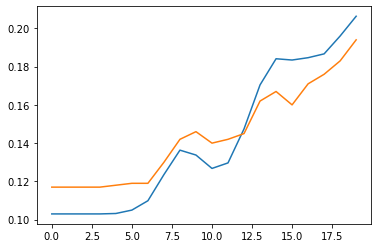

In [26]:
plt.plot(train_history)
plt.plot(val_history)

### For increasing the Neural Net learning speed we introduce learning rate decay.

In [27]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-4)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2, learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.302307, Train accuracy: 0.103444, val accuracy: 0.101000
Loss: 2.302480, Train accuracy: 0.103444, val accuracy: 0.101000
Loss: 2.302496, Train accuracy: 0.103444, val accuracy: 0.101000
Loss: 2.302489, Train accuracy: 0.103444, val accuracy: 0.101000
Loss: 2.302489, Train accuracy: 0.108444, val accuracy: 0.102000
Loss: 2.302582, Train accuracy: 0.123778, val accuracy: 0.116000
Loss: 2.302381, Train accuracy: 0.120222, val accuracy: 0.115000
Loss: 2.302358, Train accuracy: 0.113444, val accuracy: 0.105000
Loss: 2.302455, Train accuracy: 0.114000, val accuracy: 0.104000
Loss: 2.302222, Train accuracy: 0.128778, val accuracy: 0.121000
Loss: 2.301095, Train accuracy: 0.146556, val accuracy: 0.143000
Loss: 2.302597, Train accuracy: 0.157556, val accuracy: 0.154000
Loss: 2.301471, Train accuracy: 0.169556, val accuracy: 0.163000
Loss: 2.301777, Train accuracy: 0.173667, val accuracy: 0.171000
Loss: 2.290136, Train accuracy: 0.176000, val accuracy: 0.169000
Loss: 2.290649, Train acc

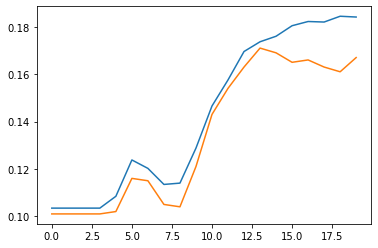

In [28]:
plt.plot(train_history)
plt.plot(val_history)

## Momentum SGD

Further proposals include the momentum method, which appeared in Rumelhart, Hinton and Williams' paper on backpropagation learning Stochastic gradient descent with momentum remembers the update Δ w at each iteration, and determines the next update as a linear combination of the gradient and the previous update:

![1](https://wikimedia.org/api/rest_v1/media/math/render/svg/3959fd86a726cd35d9aeaeaf78ed5006303f7951)
![2](https://wikimedia.org/api/rest_v1/media/math/render/svg/9305a474135c05fa8767aebd66c404e189506d03)

that leads to:

![3](https://wikimedia.org/api/rest_v1/media/math/render/svg/350886f1e3aaa6e9352caca8581274df95ac54e6)

where the parameter w which minimizes Q(w) is to be estimated, eta is a step size and alpha  is an exponential decay factor between 0 and 1 that determines the relative contribution of the current gradient and earlier gradients to the weight change.

The name momentum stems from an analogy to momentum in physics: the weight vector w, thought of as a particle traveling through parameter space, incurs acceleration from the gradient of the loss ("force"). Unlike in classical stochastic gradient descent, it tends to keep traveling in the same direction, preventing oscillations [source](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). 

In [29]:
class MomentumSGD:
    """
    Implements Momentum SGD update.
    """
    def __init__(self, momentum=0.9):
        self.momentum = momentum
        self.velocity = 0
    
    def update(self, w, d_w, learning_rate, batch_size):
        """
        Performs Momentum SGD update.
        
        Args:
        w (numpy array): weights.
        d_w (numpy array same shape as w): gradient.
        learning_rate (float): learning rate.
        
        Returns:
        updated_weights (numpy array same shape as w)
        """
        self.velocity = self.momentum * self.velocity - learning_rate * d_w / batch_size
        w = w + self.velocity
        return w

In [30]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-4)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=0.02, learning_rate_decay=0.99)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.302718, Train accuracy: 0.100889, val accuracy: 0.094000
Loss: 2.302482, Train accuracy: 0.100889, val accuracy: 0.094000
Loss: 2.302560, Train accuracy: 0.101111, val accuracy: 0.094000
Loss: 2.302499, Train accuracy: 0.102667, val accuracy: 0.094000
Loss: 2.302983, Train accuracy: 0.105444, val accuracy: 0.096000
Loss: 2.302820, Train accuracy: 0.109222, val accuracy: 0.101000
Loss: 2.302674, Train accuracy: 0.112778, val accuracy: 0.102000
Loss: 2.302207, Train accuracy: 0.116778, val accuracy: 0.105000
Loss: 2.302303, Train accuracy: 0.120778, val accuracy: 0.108000
Loss: 2.301380, Train accuracy: 0.125778, val accuracy: 0.114000
Loss: 2.301619, Train accuracy: 0.131778, val accuracy: 0.118000
Loss: 2.301244, Train accuracy: 0.138111, val accuracy: 0.125000
Loss: 2.301119, Train accuracy: 0.149778, val accuracy: 0.137000
Loss: 2.302776, Train accuracy: 0.164000, val accuracy: 0.145000
Loss: 2.296495, Train accuracy: 0.174333, val accuracy: 0.150000
Loss: 2.291671, Train acc

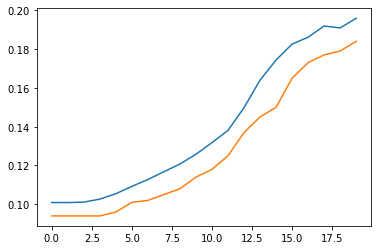

In [31]:
plt.plot(train_history)
plt.plot(val_history)

We achived higher accuracy with the same parameters but different optimizer.

## Let's train a model.
But before we'll check that everything is correct. With this level of complexity we can expect the model to overfit on training set and achieve 100 % accuracy.

In [32]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302766, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302934, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302372, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302436, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302422, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302743, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.300875, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302380, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302510, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.302367, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 2.293077, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.285496, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.277095, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.262382, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.235501, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.295062, Train acc

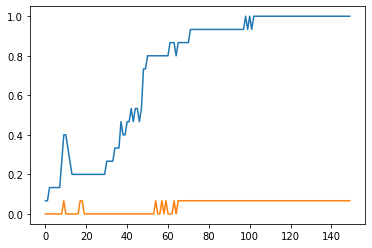

In [33]:
plt.plot(train_history)
plt.plot(val_history)

Looks like that everything is correct.

### Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less.

In [34]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, learning_rate_decay=0.999,
                  num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.303322, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.302594, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.302979, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.302566, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: 2.301917, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.301659, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 2.302490, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.302001, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 2.302550, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.296779, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.288683, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.303428, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.291908, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.294023, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.282764, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.289479, Train acc

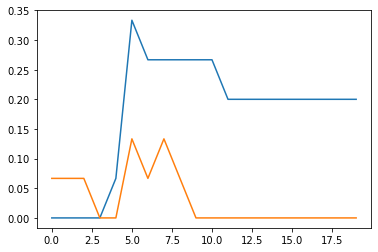

In [35]:
plt.plot(train_history)
plt.plot(val_history)

Adjusting learning rate decay worked.

## Let's train the best one-hidden-layer network we can!

In [36]:
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
reg_strengths = [1e-1, 1e-2, 1e-3, 1e-4]
learning_rate_decays = [0.9, 0.99, 0.999]
hidden_layer_sizes = [32, 64, 128, 256]
num_epochs = [50, 100, 200]
batch_sizes = [32, 64, 128]
optimizers = [SGD(), MomentumSGD()]

dataset = Dataset(train_X, train_y, val_X, val_y)

### We'll tune hyperparameters of our model.

Firstly we'll choose default state of the model. We should choose default state in a such way that our hyperparameters tweakes are actually seen on train/validation accuracy plot. It demands experimenting a bit with a hyperparameters first to see changes.

#### Learning rate

In [37]:
loss_histories = list()
train_histories = list()
val_histories = list()

for lr in learning_rates:
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 32, reg = 1e-3)
    trainer = Trainer(model, dataset, SGD(), learning_rate=lr, learning_rate_decay=0.9,
                      num_epochs=50, batch_size=32)
    loss_history, train_history, val_history = trainer.fit(verbose=False)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)
    

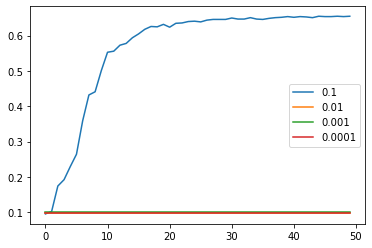

In [38]:
count = 0
for val in val_histories:
    plt.plot(val, label = learning_rates[count])
    plt.legend()
    count += 1

To see any notable difference with changing learning rate hyperparameters, I tried different regularization strength. It was a good bet.
We'll fix the best learning rate in our model and move further with other hyperparameters.

#### Regularization strength.

In [39]:
loss_histories = list()
train_histories = list()
val_histories = list()

for rs in reg_strengths:
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 32, reg = rs)
    trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=0.9,
                     num_epochs=50, batch_size=32)
    loss_history, train_history, val_history = trainer.fit(verbose=False)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)
    

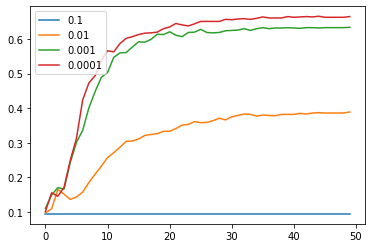

In [40]:
count = 0
for val in val_histories:
    plt.plot(val, label = reg_strengths[count])
    plt.legend()
    count += 1

As in previous step we choose the best hyperparameter we spotted. So our default model differs from initial in learning rate and regularization strength. We'll continue set up hyperparameters one by one.

#### Learning rate decay.

In [41]:
loss_histories = list()
train_histories = list()
val_histories = list()

for lrd in learning_rate_decays:
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 32, reg = 1e-4)
    trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=lrd,
                     num_epochs=50, batch_size=32)
    loss_history, train_history, val_history = trainer.fit(verbose=False)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)    

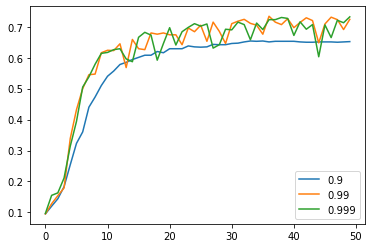

In [42]:
count = 0
for val in val_histories:
    plt.plot(val, label = learning_rate_decays[count])
    plt.legend()
    count += 1

#### Hidden layer size.

In [43]:
loss_histories = list()
train_histories = list()
val_histories = list()

for hls in hidden_layer_sizes:
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hls, reg = 1e-4)
    trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=0.99,
                     num_epochs=50, batch_size=32)
    loss_history, train_history, val_history = trainer.fit(verbose=False)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)

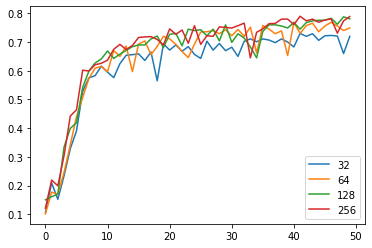

In [44]:
count = 0
for val in val_histories:
    plt.plot(val, label = hidden_layer_sizes[count])
    plt.legend()
    count += 1

#### Number of epochs.

In [45]:
loss_histories = list()
train_histories = list()
val_histories = list()

for epoch in num_epochs:
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 256, reg = 1e-4)
    trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=0.99,
                     num_epochs=epoch, batch_size=32)
    loss_history, train_history, val_history = trainer.fit(verbose=False)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)

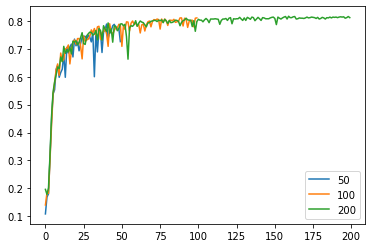

In [46]:
count = 0
for val in val_histories:
    plt.plot(val, label = num_epochs[count])
    plt.legend()
    count += 1

#### Batch size.

In [47]:
loss_histories = list()
train_histories = list()
val_histories = list()

for bs in batch_sizes:
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 256, reg = 1e-4)
    trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=0.99,
                     num_epochs=200, batch_size=bs)
    loss_history, train_history, val_history = trainer.fit(verbose=False)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)

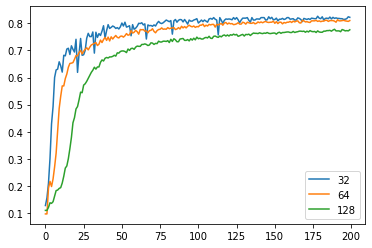

In [48]:
count = 0
for val in val_histories:
    plt.plot(val, label = hidden_layer_sizes[count])
    plt.legend()
    count += 1

#### Optimizers.

In [49]:
loss_histories = list()
train_histories = list()
val_histories = list()

for opt in optimizers:
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 256, reg = 1e-4)
    trainer = Trainer(model, dataset, opt, learning_rate=1e-1, learning_rate_decay=0.99,
                     num_epochs=200, batch_size=32)
    loss_history, train_history, val_history = trainer.fit(verbose=False)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)

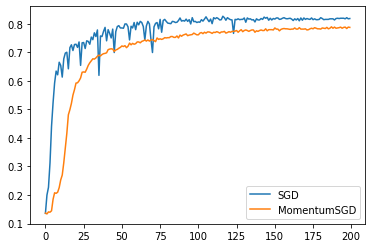

In [50]:
count = 0
optimizers_names = ["SGD", "MomentumSGD"]
for val in val_histories:
    plt.plot(val, label = optimizers_names[count])
    plt.legend()
    count += 1

# The Best Model.

    learning_rates = 1e-1
    reg_strengths = 1e-4
    learning_rate_decays = 0.99
    hidden_layer_sizes = 256
    num_epochs = 200
    batch_sizes = 32
    optimizers = SGD()

In [51]:
best_classifier = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, 
                              hidden_layer_size = 256, reg = 1e-4)
trainer = Trainer(best_classifier, dataset, MomentumSGD(), learning_rate=1e-1,
                  learning_rate_decay=0.99, num_epochs=200, batch_size=32)
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302925, Train accuracy: 0.103000, val accuracy: 0.117000
Loss: 2.302433, Train accuracy: 0.103000, val accuracy: 0.117000
Loss: 2.302471, Train accuracy: 0.103000, val accuracy: 0.117000
Loss: 2.302856, Train accuracy: 0.104778, val accuracy: 0.118000
Loss: 2.301647, Train accuracy: 0.156778, val accuracy: 0.149000
Loss: 2.303077, Train accuracy: 0.185889, val accuracy: 0.187000
Loss: 2.295882, Train accuracy: 0.198000, val accuracy: 0.192000
Loss: 2.272270, Train accuracy: 0.204222, val accuracy: 0.184000
Loss: 2.261643, Train accuracy: 0.194111, val accuracy: 0.177000
Loss: 2.192751, Train accuracy: 0.210667, val accuracy: 0.196000
Loss: 2.132047, Train accuracy: 0.252222, val accuracy: 0.236000
Loss: 1.870568, Train accuracy: 0.283667, val accuracy: 0.269000
Loss: 1.949317, Train accuracy: 0.318000, val accuracy: 0.307000
Loss: 1.573458, Train accuracy: 0.385778, val accuracy: 0.368000
Loss: 1.934355, Train accuracy: 0.435333, val accuracy: 0.416000
Loss: 1.677940, Train acc

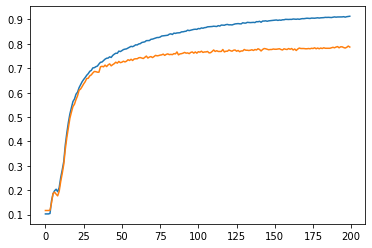

In [52]:
plt.plot(train_history)
plt.plot(val_history)

# Let's look how our best model behaves on test data.

In [53]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.785000
